# TechLab Big Data - Direct Marketing

## 2. Preparazione del Dataset

### Import delle librerie

Come prima cosa importiamo le librerie e i moduli che saranno necessari per l'implementazione del caso di studio. 

Le librerie di interesse sono: 

- Pandas: per la manipolazione di dati in formato sequenziale o tabellare;
- Matplot e Seaborn: per la generazione di grafici; 
- Scikit-learn: per i modelli di Machine Learning.

In [32]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')
from inspect import signature
%matplotlib inline

from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import KFold, train_test_split
from sklearn                   import metrics
from sklearn.ensemble          import GradientBoostingClassifier
from sklearn.svm               import SVC
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.metrics           import classification_report, precision_score, recall_score, f1_score
from sklearn                   import tree
from sklearn.utils             import resample
from inspect                   import signature

Importiamo il dataset e mostriamo le prime osservazioni per capire com'è strutturato.

In [33]:
bank = pd.read_csv('Data/campagna-target.csv', sep = ';')
bank.head()

,eta,professione,stato_civile,istruzione,default,prestito_casa,prestito_personale,mese,giorno_settimana,campagne,giorni_p,precedente,outcome_p,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Codifica delle variabili categoriche

Per fare in modo che le variabili vengano interpretate nel modo corretto, è necessario trasformare tutte le variabili categoriche. La trasformazione in questione è detta "One-hot Encoding" e viene effettuata nel modo seguente: 

- per ogni variabile categorica a n livelli, vengono create n-1 nuove colonne che corrispondono ai livelli; 
- le colonne sono popolate con valori 0 e 1; 
- ogni osservazione ha valore 1 nella colonna corrispondente al livello che assume l'osservazione stessa. 

Vengono create n-1 colonne e non una per ogni livello perchè è possibile dedurre il valore dell'n-esimo livello conoscendo gli altri n-1 valori, così facendo si eliminano problemi nell'esecuzione degli algoritmi dovuti alla collinearità delle variabili.  
<br> 
Come esempio, analizziamo la variabile "Stato_civile". Questa variabile assume 4 valori distinti: married, single, divorced e unknown. Seguendo la procedura spiegata precedentemente, vengono create 4-1 colonne relative a 3 dei livelli della variabile, in questo caso: married, single e unknown. Il valore divorced viene preso come valore di riferimento e può essere dedotto dai valori che assumono le altre colonne. Per l'osservazione 10, ad esempio, il valore della variabile "Stato_civile" era uguale a married, quindi, viene inserito il valore 1 nella colonna stato_civile_married e 0 in tutte le altre. Analogamente, per l'osservazione 11 il valore della variabile "Stato_civile" era uguale a single e quindi il valore 1 è sotto la colonna stato_civile_single. Avessimo trovato un'osservazione per la quale tutti e 3 i valori di queste colonne fosse stato uguale a zero, avremmo potuto dedurre che il valore della variabile "Stato_civile" era divorced, in quanto è l'unica colonna mancante.

In [34]:
bank_final = pd.get_dummies(bank.drop('y', axis=1), drop_first= True)
bank_final.iloc[10:16, 19:22]

,stato_civile_married,stato_civile_single,stato_civile_unknown
10,1,0,0
11,0,1,0
12,0,1,0
13,0,0,0
14,1,0,0
15,1,0,0


La variabile target è anch'essa una variabile categorica. In questo caso si tratta di una variabile binaria quindi non è necessaria la creazione di altre colonne e i suoi valori di partenza verranno ricodificati in 0 e 1, dove 1 equivale a "yes" e 0 a "no". 

In [35]:
y = pd.get_dummies(bank['y'], columns = ['y'], drop_first = True)
y[39000:39011]

,yes
39000,1
39001,1
39002,0
39003,1
39004,1
39005,1
39006,0
39007,1
39008,1
39009,1


### Codifica delle variabili numeriche

Anche per le varibili numeriche è necessario applicare una trasformazione: bisogna standardizzare i loro valori rispetto alla media e la deviazione standard dell'intera colonna. Anche questa trasformazione viene effettuta per migliorare le performance degli algoritmi che verranno utilizzati in seguito. 
<br>
Infine, concatenando l'insieme della varibili dipendenti e la variabile target, otteniamo così il dataset finale. 


In [36]:
bank_final1 = pd.concat([bank_final, y], axis = 1)
bank_scale_col = bank_final1.columns[0:9]

bank_scale_mean =  bank_final1.iloc[:, 0:9].mean()
bank_scale_std =  bank_final1.iloc[:, 0:9].std()

sc_bank = StandardScaler()
bank_scale = pd.DataFrame(sc_bank.fit_transform(X=bank_final1[['eta', 'campagne', 'giorni_p', 'precedente', 'emp.var.rate',
                                           'cons.price.idx','cons.conf.idx', 'euribor3m','nr.employed']]) ,
                         columns = bank_scale_col)

bank_dummy = bank_final1.iloc[:, 9:]
bank_final1 = pd.concat([bank_scale, bank_dummy], axis=1)
bank_final1.head()

,eta,campagne,giorni_p,precedente,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,professione_blue-collar,...,mese_nov,mese_oct,mese_sep,giorno_settimana_mon,giorno_settimana_thu,giorno_settimana_tue,giorno_settimana_wed,outcome_p_nonexistent,outcome_p_success,yes
0,1.820649,-0.568525,0.187468,-0.344607,0.635621,0.720971,0.921994,0.699023,0.312057,0,...,0,0,0,1,0,0,0,1,0,0
1,1.928158,-0.568525,0.187468,-0.344607,0.635621,0.720971,0.921994,0.699023,0.312057,0,...,0,0,0,1,0,0,0,1,0,0
2,-0.222024,-0.568525,0.187468,-0.344607,0.635621,0.720971,0.921994,0.699023,0.312057,0,...,0,0,0,1,0,0,0,1,0,0
3,0.100503,-0.568525,0.187468,-0.344607,0.635621,0.720971,0.921994,0.699023,0.312057,0,...,0,0,0,1,0,0,0,1,0,0
4,1.820649,-0.568525,0.187468,-0.344607,0.635621,0.720971,0.921994,0.699023,0.312057,0,...,0,0,0,1,0,0,0,1,0,0


### Training e Test Set

Il primo step per l'implementazione di un algoritmo di Machine Learning, è la suddivisione del dataset a disposizione in training e test set. Le osservazioni appartenenti al primo set verranno utilizzate per trainare il modello vero e proprio, mentre quelle del secondo set verranno utilizzate per controllare la qualità del modello creato a partire dal training set. 
<br> Normalmente il dataset iniziale viene suddiviso nel modo seguente: 
- 70-75% dei dati viene utilizzato per il Training Set;
- 30-25% dei dati viene utilizzato per il Test Set. 

In aggiunta, utilizziamo una tecnica di validazione chiamata Cross-Validation per ottenere una migliore stima dell'accuratezza del modello. In particolare, il metodo utilizzato è il k-fold. Il dataset iniziale viene suddiviso in k sottoinsiemi della stessa dimensione di cui k-1 vengono utilizzati come Training Set e 1 come Test Set. Il processo viene poi iterato k volte in modo tale che ogni sottoinsieme venga utilizzato esattamente una volta come Test Set. Si può quindi fare una media dei k valori ottenuti da ogni singola iterazione per avere una stima più precisa dell'accuratezza del modello.   

In [37]:
X_train, X_test, y_train, y_test = train_test_split(bank_final1.drop('yes', axis = 1), 
                                                    bank_final1['yes'], test_size = 0.25, random_state = 101)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

print('Osservazioni del Training Set: ',len(X_train))
print('Osservazioni del Test Set:     ',len(X_test))
print('Percentuale Training Set rispetto al totale: ', round((len(X_train)/len(bank_final1))*100,2), '%')

Osservazioni del Training Set:  29601
Osservazioni del Test Set:      9867
Percentuale Training Set rispetto al totale:  75.0 %


### Dataset non bilanciato e Upsampling

Il dataset risulta essere sbilanciato in quanto le frequenze dei valori assunti dalla variabile target sono molto diverse tra loro. Infatti il numero di risposte positive risulta essere molto minore rispetto alle risposte negative.

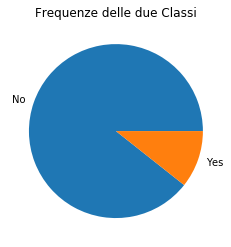

Percentuale della classe in minoranza rispetto al totale:  10.66 %


In [38]:
fig, ax = plt.subplots()
frequency = bank_final1['yes'].value_counts()
ax.pie(frequency,
            labels = ['No', 'Yes'])
ax.set(title = 'Frequenze delle due Classi')
plt.show()

print('Percentuale della classe in minoranza rispetto al totale: ',round((len(bank_final1[bank_final1['yes'] == 1])/len(bank_final1))*100,2),'%')

Anche considerando soltanto le osservazioni presenti nel Training Set, si continua a constatare un disequilibrio della stessa percentuale tra le due classi. 

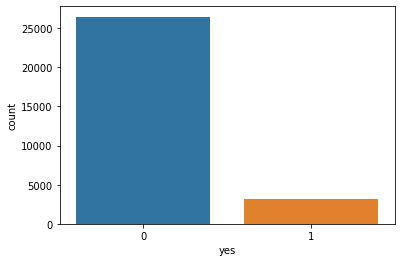

Percentuale della classe in minoranza rispetto al totale:  10.6 %


In [39]:
ax = sns.countplot(x=y_train)
plt.show()

print('Percentuale della classe in minoranza rispetto al totale: ',round((len(y_train[y_train == 1])/len(y_train))*100,2),'%')

Per migliorare questa situazione, che potrebbe portare alla formulazione di modelli di accuratezza ridotta, si può ricorre a varie tecniche di ricampionamento del dataset.
<br> In questo caso useremo la tecnica nota come Upsampling del Training Set per creare classi più bilanciate. 
Per aumentare il numero di osservazioni della classe in difetto, nel nostro caso quella con y = 'yes', effettuiamo un campionamento con reinserimento dalla classe in minoranza per raddoppiare il numero di osservazioni appartenenti a questa categoria.

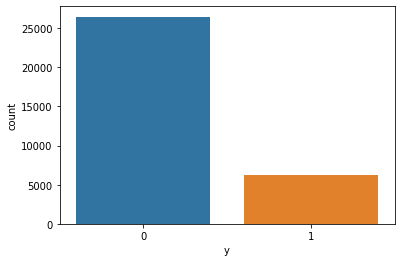

Percentuale della classe in minoranza rispetto al totale:  19.18 %


In [40]:
df_total = pd.concat([X_train, y_train], axis=1)

df_majority = df_total[df_total['yes'] == 0]
df_minority = df_total[df_total['yes'] == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples= int(3139*2),
                                 random_state=123) 


df_upsampled = pd.concat([df_majority, df_minority_upsampled])
y_new = df_upsampled['yes']

ax = sns.countplot(x='yes', data = df_upsampled)
ax.set_xlabel('y')
plt.show()

print('Percentuale della classe in minoranza rispetto al totale: ',round((len(df_upsampled[df_upsampled['yes'] == 1])/len(df_upsampled))*100,2),'%')

X_train = df_upsampled.drop('yes', axis=1)
y_train = df_upsampled['yes']

Ora che i dati sono pronti, possiamo passare alla formulazione effettiva dei modelli che potranno esserci utili a raggiungere l'obiettivo. 

Esportiamo le variabili di interesse che abbiamo formulato fino ad ora in modo da poterle utilizzare nei notebook successivi.

In [41]:
with open("Data/X_train.pickle","wb") as f:
        pickle.dump(X_train, f)
with open("Data/y_train.pickle","wb") as d:
        pickle.dump(y_train, d)
with open("Data/X_test.pickle","wb") as g:
        pickle.dump(X_test, g)
with open("Data/y_test.pickle","wb") as h:
        pickle.dump(y_test, h)
with open("Data/bank_final1.pickle","wb") as i:
        pickle.dump(bank_final1, i)
with open("Data/k_fold.pickle","wb") as j:
        pickle.dump(k_fold, j)
with open("Data/bank_scale_std.pickle","wb") as k:
        pickle.dump(bank_scale_std, k)
with open("Data/bank_scale_mean.pickle","wb") as l:
        pickle.dump(bank_scale_mean, l)